# Library

In [5]:
# Library to dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Library tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Surpress warning
import warnings
warnings.filterwarnings("ignore")

# Library sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# pickle
import pickle


# Dataset

In [6]:
# Download dataset
od.download("https://www.kaggle.com/datasets/ahmadhabibhasanzein/suicide-detection-clean")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Your Kaggle Key: Dataset URL: https://www.kaggle.com/datasets/ahmadhabibhasanzein/suicide-detection-clean


100%|██████████| 83.7M/83.7M [00:59<00:00, 1.47MB/s]


In [7]:
# Read dataset
data = pd.read_csv('suicide-detection-clean/clean_text.csv')
data.head()

,text,class,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...
3,i need helpjust help me im crying so hard,suicide,need helpjust help im crying hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,losthello name adam struggling years afraid pa...


# Encoding

In [8]:
X = data['clean_text'].astype(str)
y = data['class']

# encode class values as integers
# Define label encoder
encoder = LabelEncoder()
# fit and transform
encoded_y = encoder.fit_transform(y)

# Test Train Split

In [9]:
# Test and train split
X_train, X_test, y_train, y_test = train_test_split(X,encoded_y, test_size=.2, random_state=42)

# Data Preprocessing

In [10]:
vocab_size = 1000
max_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

# List Resource

In [11]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[]

In [12]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Bidirectional LSTM 1 Layer

In [13]:
embedding_dim = 16
with mirrored_strategy.scope():
# Initialize the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the callbacks
# Save the best model in .keras format (recommended by Keras)
checkpoint_callback = ModelCheckpoint(filepath="Bidirectional-LSTM-1-Layers.keras", 
                                      save_best_only=True, 
                                      monitor="val_accuracy", 
                                      mode="max", 
                                      verbose=1, 
                                      save_weights_only=False)  # Ensure it saves the full model

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", 
                                        mode="max", 
                                        patience=5, 
                                        verbose=1, 
                                        restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", 
                                       factor=0.1, 
                                       patience=5, 
                                       verbose=1, 
                                       mode="min", 
                                       min_delta=0.0001, 
                                       cooldown=0, 
                                       min_lr=0)

# Callbacks list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout

# If you're not using MirroredStrategy (single-GPU or CPU):
strategy = tf.distribute.get_strategy()  # Use the default strategy if you're not in a multi-GPU setup

# Rebuild your model inside the strategy scope if needed
with strategy.scope():
    # Define the model
    model = Sequential([
        Embedding(input_dim=10000, output_dim=100, input_length=200),  # Adjust based on your vocab size and sequence length
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # Adjust based on your problem (binary classification)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model for only 1 epoch
    history = model.fit(
        training_padded, training_labels,
        epochs=1,  # Train for only 1 epoch
        validation_data=(testing_padded, testing_labels),
        callbacks=callbacks,
        batch_size=128
    )


1451/1451 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5002 - loss: 0.6934
Epoch 1: val_accuracy improved from -inf to 0.49820, saving model to Bidirectional-LSTM-1-Layers.keras
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 1860s 1s/step - accuracy: 0.5002 - loss: 0.6934 - val_accuracy: 0.4982 - val_loss: 0.6932 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


In [24]:
# Evaluate the model
results_base = model.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_base[0]} - Accuracy: {100*results_base[1]}%')

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 182s 125ms/step - accuracy: 0.4963 - loss: 0.6933
Test results - Loss: 0.6932228803634644 - Accuracy: 49.820101261138916%


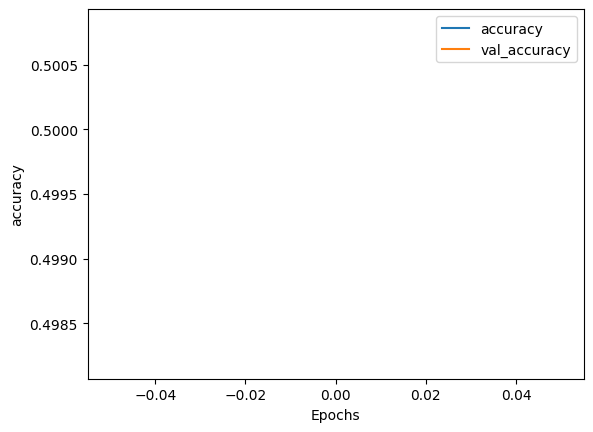

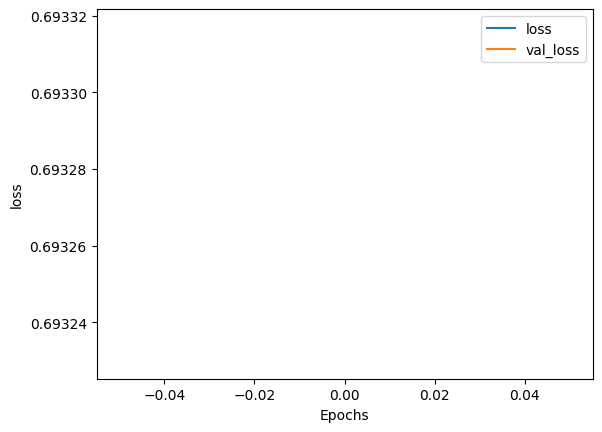

In [25]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Testing Model

In [13]:
# Load all model
BiLSTM1L_Model = tf.keras.models.load_model('Bidirectional-LSTM-1-Layers.keras')

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your pre-trained model (update the path with the actual location of your model)
model_base = load_model('Bidirectional-LSTM-1-Layers.keras')

# Define the tweet
twt = ['i m great man i love my life and this world']

# Tokenize the text (ensure tokenizer is defined)
twt = tokenizer.texts_to_sequences(twt)

# Ensure max_length matches the value used during training
max_length = 180 # Adjust if necessary

# Pad the sequence to the correct length
twt = pad_sequences(twt, maxlen=max_length, padding='post', truncating='post')

# Predict the sentiment
prediction_base = model_base.predict(twt)

# Print the prediction
if prediction_base[0] >= 0.5:
    print("Non Suicide Post")
else:
    print("Potential Suicide Post")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Non Suicide Post


In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load your pre-trained model (update the path with the actual location of your model)
model_base = load_model('Bidirectional-LSTM-1-Layers.keras')

# Define the tweet
twt = ['I live']

# Tokenize the text (ensure tokenizer is defined)
twt = tokenizer.texts_to_sequences(twt)

# Ensure max_length matches the value used during training
max_length = 180 # Adjust if necessary

# Pad the sequence to the correct length
twt = pad_sequences(twt, maxlen=max_length, padding='post', truncating='post')

# Predict the sentiment
prediction_base = model_base.predict(twt)

# Print the prediction
if prediction_base[0] >= 0.5:
    print("Non Suicide Post")
else:
    print("Potential Suicide Post")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Non Suicide Post


## Testing BiLSTM 1 Layers

In [24]:
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the trained model
model_path = "Model_Basic_GAP.keras"  # Update with your model's file path
model = load_model(model_path)

# Define the tweet
twt = ['I die']

# Ensure max_length, padding_type, and trunc_type are defined
max_length = 200  # Adjust based on your model's input requirement
padding_type = 'post'
trunc_type = 'post'

# Tokenize and pad the sequence
twt_sequences = tokenizer.texts_to_sequences(twt)
twt_padded = pad_sequences(twt_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Predict the sentiment
prediction = model.predict(twt_padded)

# Print the prediction
if prediction[0] >= 0.5:  # Assuming sigmoid activation for binary classification
    print("Non Suicide Post")
else:
    print("Potential Suicide Post")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Potential Suicide Post
